<a href="https://colab.research.google.com/github/BrenooOliveira/AulasFatec/blob/main/grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [9]:
# Tabela de clientes
df_clientes = pd.DataFrame([
    ("empA", "PJ", "00.000.000/0001-01"),
    ("PJ1A", "PJ", "11.111.111/0001-11"),
    ("PF1B", "PF", "222.222.222-22"),
    ("PF2A", "PF", "333.333.333-33"),
    ("PF2B", "PF", "444.444.444-44"),
], columns=["codigo_cliente", "tipo_pessoa", "documento"])
df_clientes.head()

,codigo_cliente,tipo_pessoa,documento
0,empA,PJ,00.000.000/0001-01
1,PJ1A,PJ,11.111.111/0001-11
2,PF1B,PF,222.222.222-22
3,PF2A,PF,333.333.333-33
4,PF2B,PF,444.444.444-44


In [10]:

# Tabela de sócios
df_socios = pd.DataFrame([
    ("empA", "PF", "222.222.222-22", 50.0),
    ("empA", "PJ", "11.111.111/0001-11", 50.0),
    ("PJ1A", "PF", "333.333.333-33", 50.0),
    ("PJ1A", "PF", "444.444.444-44", 50.0),
], columns=["codigo_cliente", "tipo_pessoa", "documento", "taxa_percentual"])

df_socios.head()

,codigo_cliente,tipo_pessoa,documento,taxa_percentual
0,empA,PF,222.222.222-22,50.0
1,empA,PJ,11.111.111/0001-11,50.0
2,PJ1A,PF,333.333.333-33,50.0
3,PJ1A,PF,444.444.444-44,50.0


In [11]:
# Construção do grafo
G = nx.DiGraph()

# Mapeamento de documento para código do cliente
doc_to_codigo = df_clientes.set_index("documento")["codigo_cliente"].to_dict()

{'00.000.000/0001-01': 'empA',
 '11.111.111/0001-11': 'PJ1A',
 '222.222.222-22': 'PF1B',
 '333.333.333-33': 'PF2A',
 '444.444.444-44': 'PF2B'}

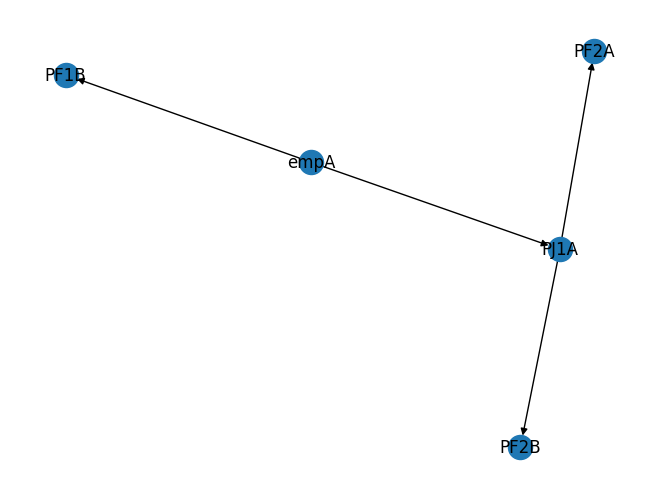

In [13]:
# Adiciona arestas ao grafo com base nos sócios
for _, row in df_socios.iterrows():
    parent = row["codigo_cliente"]
    doc = row["documento"]
    child = doc_to_codigo[doc]
    pct = row["taxa_percentual"] / 100
    G.add_edge(parent, child, pct=pct)
nx.draw(G, with_labels=True)
plt.show()

In [21]:
# Função para identificar beneficiários finais de uma empresa
def encontrar_beneficiarios(grafo, raiz, df_clientes):
    # Dicionário que irá armazenar os beneficiários finais (PF) e seus percentuais acumulados
    finais = {}

    # Função interna (recursiva) que realiza uma busca em profundidade (DFS)
    def dfs(no, participacao):
        # Verifica o tipo de pessoa do nó atual (PF ou PJ)
        tipo = df_clientes.set_index("codigo_cliente").loc[no, "tipo_pessoa"]

        if tipo == "PF":
            # Se for Pessoa Física, adiciona ou acumula a participação atual
            finais[no] = finais.get(no, 0) + participacao
        else:
            # Se for Pessoa Jurídica, percorre todos os filhos (sócios) no grafo
            for _, filho, data in grafo.out_edges(no, data=True):
                # Calcula a nova participação (multiplica o acumulado pelo percentual do filho)
                nova_part = participacao * data["pct"]
                # Chama recursivamente a função para o próximo nível da árvore
                dfs(filho, nova_part)

    # Inicia a DFS a partir da raiz (empresa analisada) com 100% de participação
    dfs(raiz, 1.0)

    # Retorna os resultados convertendo de fração para percentual (ex: 0.25 → 25.0%)
    return {k: round(v * 100, 2) for k, v in finais.items()}


In [22]:
# Aplicar para empA
participacoes_finais = encontrar_beneficiarios(G, "empA", df_clientes)
participacoes_finais

{'PF1B': 50.0, 'PF2A': 25.0, 'PF2B': 25.0}

In [19]:
# Visualizar o grafo
def desenhar_grafo(grafo, participacoes):
    pos = nx.spring_layout(grafo, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(grafo, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
    edge_labels = {(u, v): f"{d['pct']*100:.0f}%" for u, v, d in grafo.edges(data=True)}
    nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels)
    for no, val in participacoes.items():
        x, y = pos[no]
        plt.text(x, y - 0.1, f"{val:.0f}%", fontsize=9, ha='center', color="green")
    plt.title("Árvore de Participações com Beneficiários Finais")
    plt.axis("off")
    plt.show()

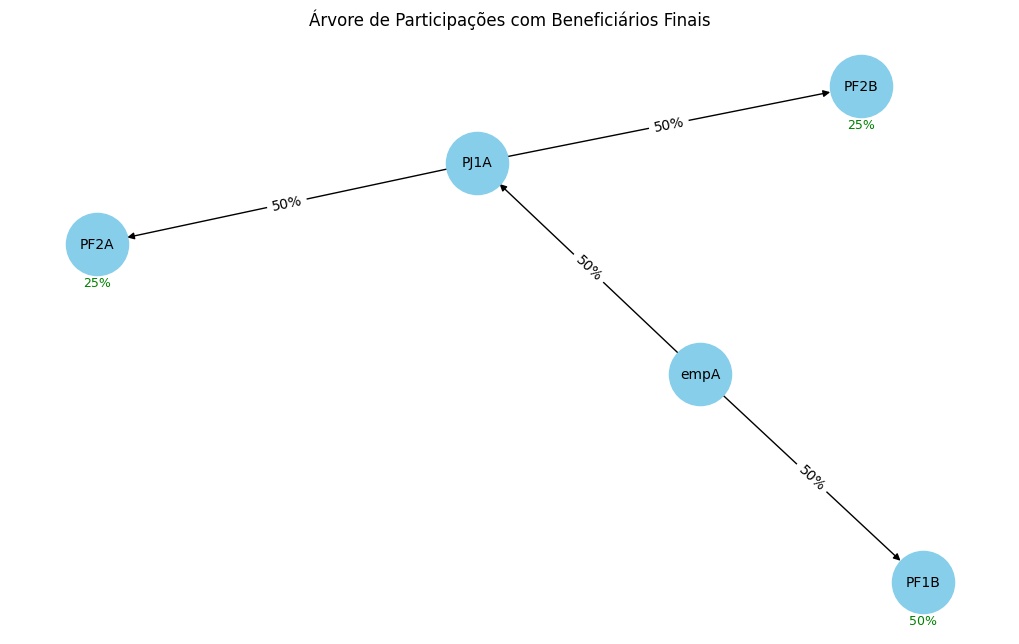

{'PF1B': 50.0, 'PF2A': 25.0, 'PF2B': 25.0}

In [20]:
desenhar_grafo(G, participacoes_finais)
participacoes_finais
